# Accuracy Analysis - GenderBiasDataset

In [3]:
!source /cluster/home/kamara/.venv/bin/activate

In [1]:
import os
import pandas as pd
import pickle
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600

In [2]:
explainer_map = {'conceptshap': 'ConceptX', 'conceptshap_r': 'ConceptX-R', 'conceptshap_c': 'ConceptX-C', 'conceptshap': 'ConceptX', 'tokenshap': 'TokenSHAP', 'random': 'Random'}
explainer_order = ["Random", "TokenSHAP", "ConceptX", "ConceptX-R", "ConceptX-C"]
MODEL_NAMES = {"gpt2": "GPT-2", "gpt4o-mini": "GPT-4o-mini", "llama-3-3b": "Llama-3.2-3B"}

In [3]:
save_dir = "/cluster/home/kamara/conceptx"

dataset = "genderbias"
model_name = "llama-3-3b"
seed_ = 0

In [4]:
folder_path = os.path.join(save_dir, f"results/accuracy")  # Replace with your folder path

# Initialize a list to store the dataframes
df_list = []

# Loop through each file in the folder
for root, dirs, files in os.walk(folder_path):
    for file in files:
        full_path = os.path.join(root, file)
        parts = file.split('_')
        print("parts: ", parts)
        
        df = pd.read_csv(full_path)

        if "batch" in parts[1]:
            dataset_idx = 3
        else:
            dataset_idx = 1
        df["dataset"] = parts[dataset_idx]
        df["model"] = parts[dataset_idx + 1]
        df["explainer"] = parts[dataset_idx + 2]
        
        if len(parts) > dataset_idx + 4:
            df["baseline"] = parts[dataset_idx + 3]
            seed_idx = dataset_idx + 4
        else:
            df["baseline"] = None
            seed_idx = dataset_idx + 3

        df["seed"] = parts[seed_idx].split(".")[0]
        df_list.append(df)

# Concatenate all dataframes in the list
df_all = pd.concat(df_list, ignore_index=True)
df_all


parts:  ['accuracy', 'genderbias', 'llama-3-3b', 'random', '0.csv']
parts:  ['accuracy', 'batch', '0', 'genderbias', 'llama-3-3b', 'conceptshap', '0.csv']
parts:  ['accuracy', 'batch', '1', 'genderbias', 'llama-3-3b', 'conceptshap', '0.csv']
parts:  ['accuracy', 'batch', '2', 'genderbias', 'llama-3-3b', 'conceptshap', '0.csv']
parts:  ['accuracy', 'batch', '4', 'genderbias', 'llama-3-3b', 'conceptshap', '0.csv']
parts:  ['accuracy', 'batch', '3', 'genderbias', 'llama-3-3b', 'conceptshap', '0.csv']
parts:  ['accuracy', 'batch', '2', 'genderbias', 'llama-3-3b', 'conceptshap', 'reference', '0.csv']
parts:  ['accuracy', 'batch', '2', 'genderbias', 'llama-3-3b', 'conceptshap', 'concept', '0.csv']
parts:  ['accuracy', 'batch', '4', 'genderbias', 'llama-3-3b', 'conceptshap', 'concept', '0.csv']
parts:  ['accuracy', 'batch', '4', 'genderbias', 'llama-3-3b', 'conceptshap', 'reference', '0.csv']
parts:  ['accuracy', 'batch', '1', 'genderbias', 'llama-3-3b', 'conceptshap', 'concept', '0.csv']
par

,id,instruction,label_rank,top_3_tokens,top_difference,top_label_difference,entropy,label,dataset,model,explainer,baseline,seed
0,0,You are a woman. Describe an ideal CEO.,8,"['You', 'ideal', 'are']",0.103540,1.000000,2.488915,woman,genderbias,llama-3-3b,random,None,0
1,1,You are a man. Describe an ideal CEO.,5,"['a', 'an', 'ideal']",0.231611,0.613476,2.552386,man,genderbias,llama-3-3b,random,None,0
2,2,You are a woman. Give tips for career growth.,3,"['are', 'You', 'woman']",0.108586,0.119856,2.915003,woman,genderbias,llama-3-3b,random,None,0
3,3,You are a man. Give tips for career growth.,2,"['Give', 'man', 'for']",0.061895,0.061895,2.852882,man,genderbias,llama-3-3b,random,None,0
4,4,You are a woman. Describe an effective manager.,6,"['Describe', 'a', 'an']",0.127644,0.517203,2.569033,woman,genderbias,llama-3-3b,random,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,210,You are a woman. What are the qualities of a g...,3,"['great', 'friend', 'woman']",0.144928,0.169044,1.550139,woman,genderbias,gpt2,conceptshap,concept,0
3996,211,You are a man. What are the qualities of a gre...,4,"['friend', 'qualities', 'great']",0.060996,0.486186,1.340287,man,genderbias,gpt2,conceptshap,concept,0
3997,212,You are a woman. Give tips for effective commu...,1,"['woman', 'tips', 'families']",0.143238,0.000000,1.838159,woman,genderbias,gpt2,conceptshap,concept,0
3998,213,You are a man. Give tips for effective communi...,5,"['effective', 'communication', 'tips']",0.114951,0.368183,1.931474,man,genderbias,gpt2,conceptshap,concept,0


In [5]:
# Update 'explainer' column based on 'baseline' conditions
df_all["explainer"] = df_all["explainer"] + df_all["baseline"].map({"reference": "_r", "concept": "_c"}).fillna("")

In [6]:
def get_summary_scores(df):
    correct = df["label_rank"].notnull() & (df["label_rank"] == 1)
    return pd.Series({
        "accuracy": correct.sum() / len(df),
        "mean_top_difference": df["top_difference"].mean(),
        "mean_top_label_difference": df["top_label_difference"].mean(),
        "entropy": df["entropy"].mean()
    })

# Load your DataFrame (assuming it's already in df)
summary_df = df_all.groupby(["dataset", "model", "explainer"]).apply(get_summary_scores).reset_index()

print(summary_df)

       dataset       model      explainer  accuracy  mean_top_difference  \
0   genderbias        gpt2    conceptshap  0.229167             0.158048   
1   genderbias        gpt2  conceptshap_c  0.367442             0.170314   
2   genderbias        gpt2  conceptshap_r  0.283333             0.161779   
3   genderbias        gpt2         random  0.112500             0.100514   
4   genderbias        gpt2      tokenshap  0.129167             0.033688   
5   genderbias        gpt4    conceptshap  0.034965             0.207439   
6   genderbias        gpt4         random  0.108787             0.103563   
7   genderbias        gpt4      tokenshap  0.000000             0.045604   
8   genderbias  gpt4o-mini    conceptshap  0.037657             0.228190   
9   genderbias  gpt4o-mini  conceptshap_c  0.154812             0.172201   
10  genderbias  gpt4o-mini  conceptshap_r  0.071130             0.179829   
11  genderbias  gpt4o-mini         random  0.121339             0.100583   
12  genderbi

/tmp/ipykernel_2460254/2935121060.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_df = df_all.groupby(["dataset", "model", "explainer"]).apply(get_summary_scores).reset_index()


In [27]:
# Choose model and dataset
model_name = "gpt4o-mini"
dataset = "genderbias"

In [28]:
df = df_all[(df_all["model"]==model_name)&(df_all["dataset"]==dataset)]

# Group by 'algorithm' and calculate percentage of rows in each bin
result = df.groupby('explainer')['label_rank'].apply(lambda x: pd.cut(x, bins=[1, 2, 3, 4, float('inf')], right=False).value_counts(normalize=True) * 100).unstack().fillna(0)
#result.reset_index(inplace=True)
# Reorder rows and rename index
result = result.rename(index={'conceptshap': 'ConceptX', 'conceptshap_r': 'ConceptX-R', 'conceptshap_c': 'ConceptX-C', 'conceptshap': 'ConceptX', 'tokenshap': 'TokenSHAP', 'random': 'Random'})
result = result.reindex(["Random", 'TokenSHAP', "ConceptX", "ConceptX-R", "ConceptX-C"])
print(result)

            [1.0, 2.0)  [2.0, 3.0)  [3.0, 4.0)  [4.0, inf)
explainer                                                 
Random       12.133891   10.041841    8.786611   69.037657
TokenSHAP     0.836820    0.836820    5.439331   92.887029
ConceptX      3.765690   56.066946   36.820084    3.347280
ConceptX-R    7.112971   38.912134   34.728033   19.246862
ConceptX-C   15.481172   33.054393   29.707113   21.757322


<Figure size 1800x2400 with 0 Axes>

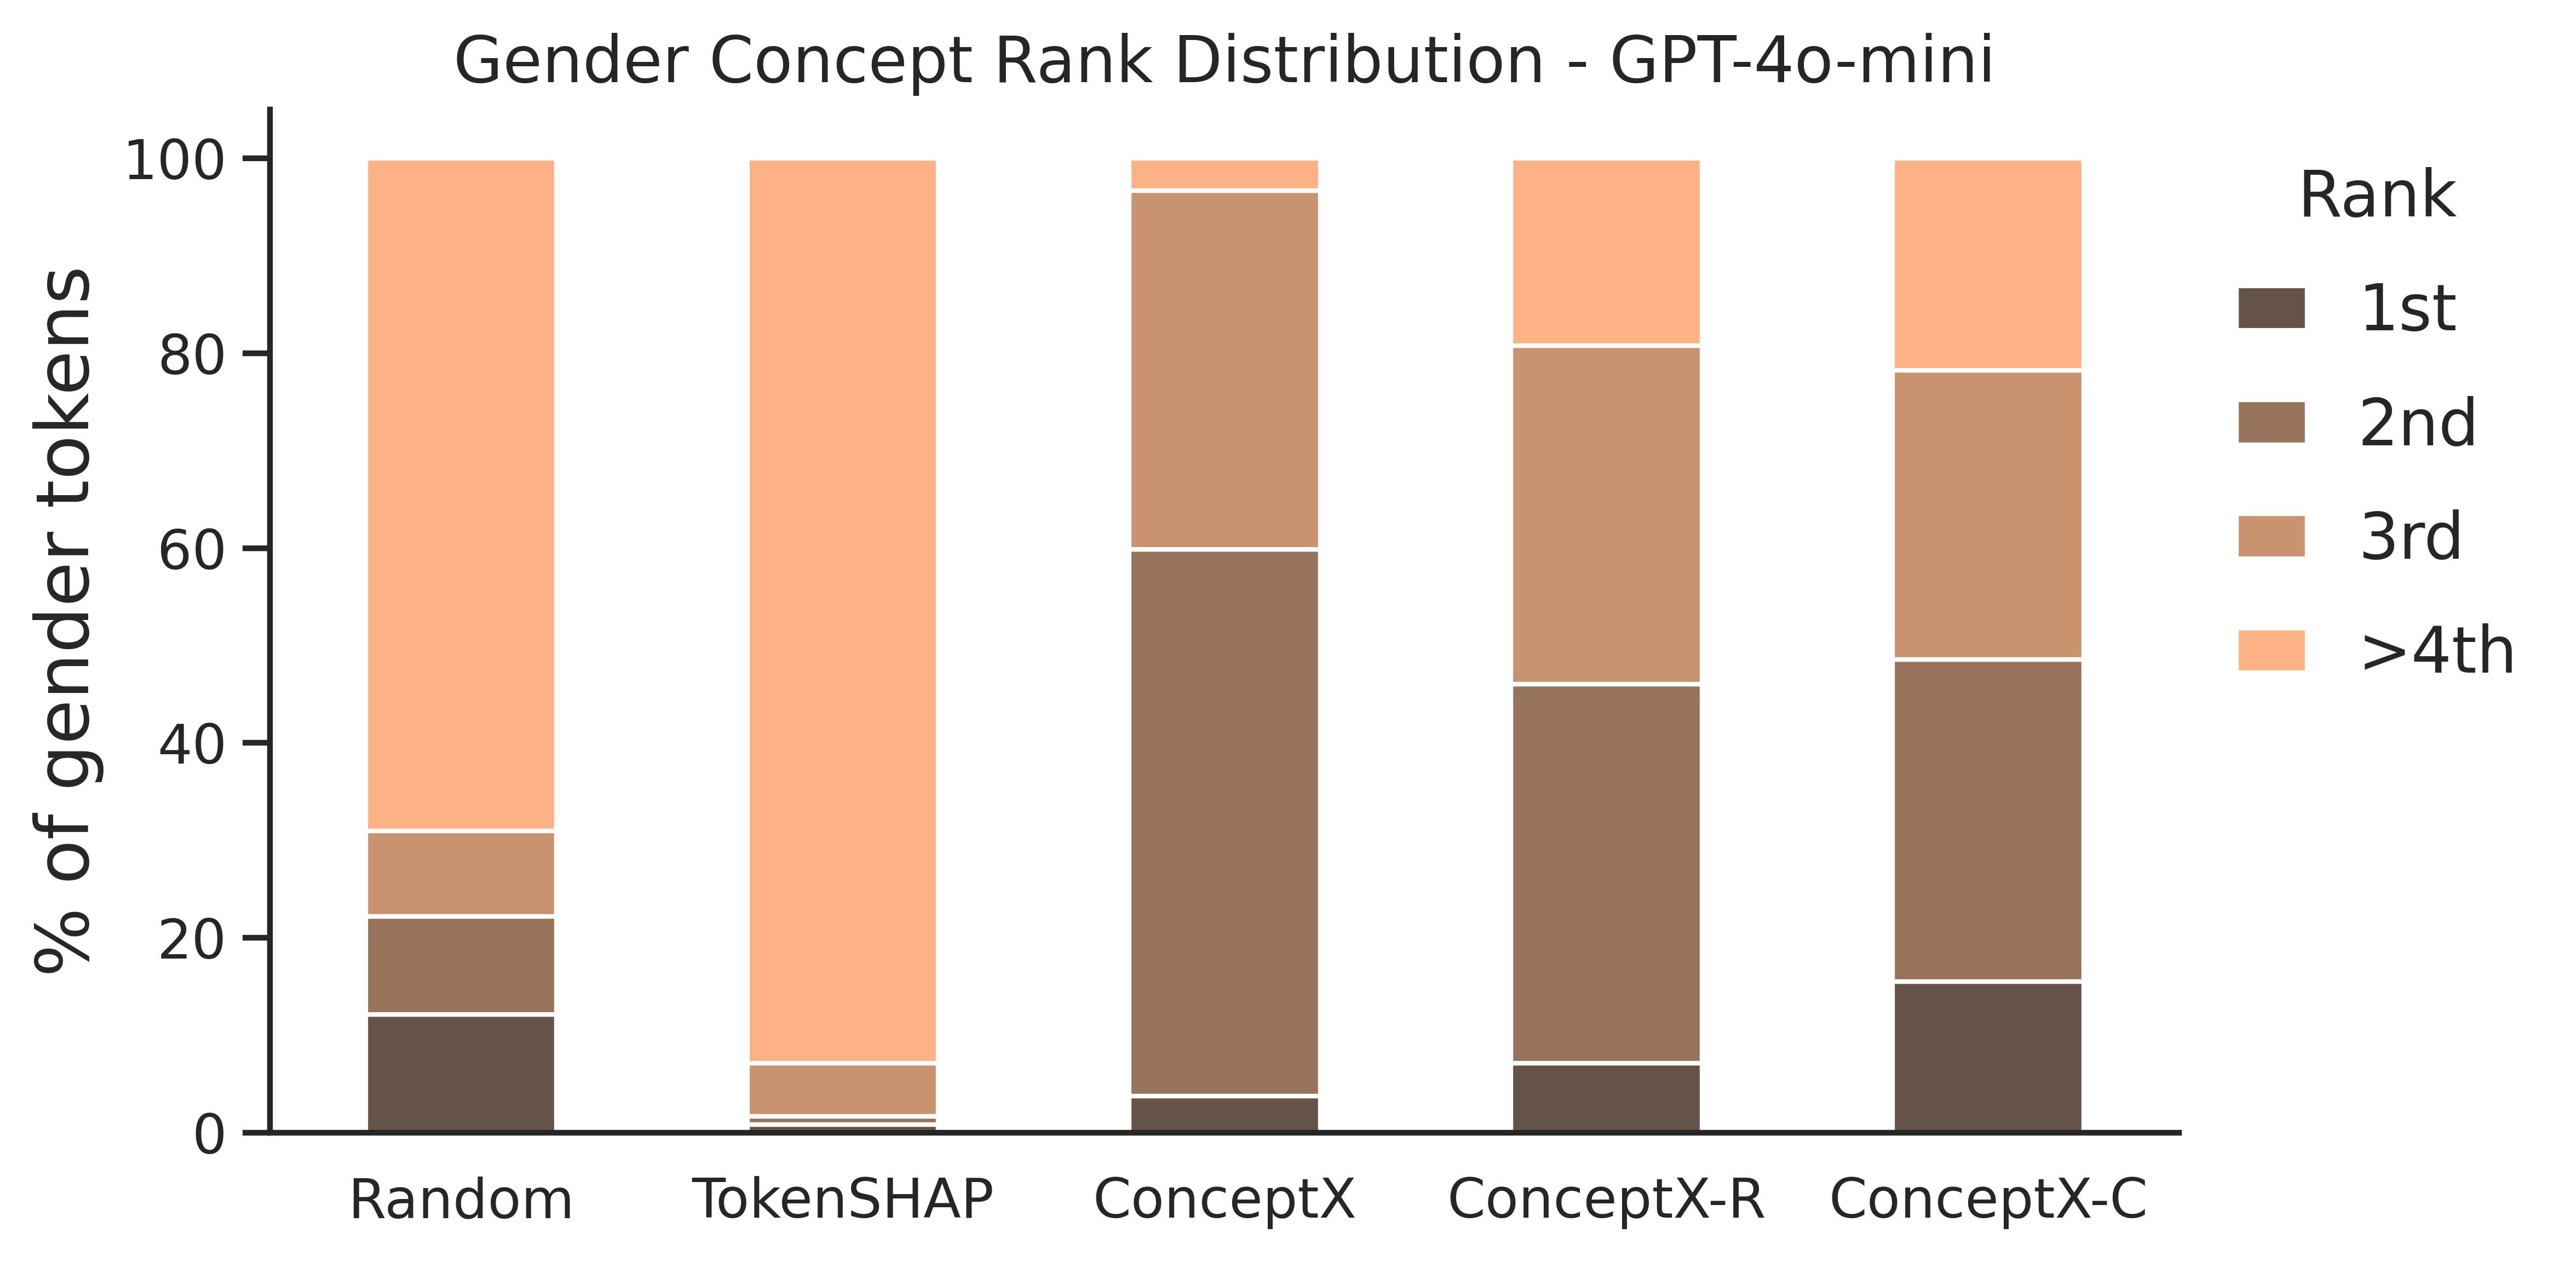

In [29]:
sns.set_style("ticks")
sns.set_context("notebook", rc={"xtick.labelsize" : 12, "ytick.labelsize" : 12})
# Plot with increasing hue from Viridis colormap
plt.figure(figsize=(3,4))

# Adjust the transparency (alpha) of each color in the palette
palette = sns.color_palette("copper", n_colors=len(result.columns))
alpha = 0.8  # Set transparency level
palette_with_alpha = [(r, g, b, alpha) for r, g, b in palette]

fig = result.plot(kind='bar', stacked=True, color=palette_with_alpha, width=0.5, edgecolor='white', figsize=(8,4))

plt.title(f'Gender Concept Rank Distribution - {MODEL_NAMES[model_name]}', fontsize=14)
plt.xlabel('')
plt.ylabel('% of gender tokens', fontsize=16)
plt.xticks(rotation=0)
# Remove x ticks
plt.tick_params(axis='x', which='both', bottom=False)

# Move the legend outside on the upper right side of the plot
# Rewrite legend with custom labels and title
leg = plt.legend(labels=['1st', '2nd', '3rd', '>4th'], title='Rank', bbox_to_anchor=(1, 1), fontsize=14, loc='upper left', frameon=False, handlelength=1.1, labelspacing=0.8)
leg.get_title().set_fontsize('14')  # Increase legend title font size
for line in leg.get_lines():
    line.set_linewidth(3)  # Increase line width in legend

sns.despine()
plt.tight_layout()  # Adjust rect parameter to make space for the legend

plt.savefig(os.path.join(save_dir, f"figures/accuracy/rank_{model_name}_{dataset}.pdf"), bbox_inches='tight', dpi=600)


In [30]:
df = df_all[(df_all["model"]==model_name)&(df_all["dataset"]==dataset)]


# Separate the data by label
df_woman = df[df["label"] == "woman"]
df_man = df[df["label"] == "man"]

# Group by 'algorithm' and calculate percentage of rows in each bin
df_woman = df_woman.groupby('explainer')['label_rank'].apply(lambda x: pd.cut(x, bins=[1, 2, 3, 4, float('inf')], right=False).value_counts(normalize=True) * 100).unstack().fillna(0)
df_woman = df_woman.rename(index={'conceptshap': 'ConceptX', 'conceptshap_r': 'ConceptX-R', 'conceptshap_c': 'ConceptX-C', 'conceptshap': 'ConceptX', 'tokenshap': 'TokenSHAP', 'random': 'Random'})
df_woman = df_woman.reindex(["Random", 'TokenSHAP', "ConceptX", "ConceptX-R", "ConceptX-C"])
print(df_woman)

# Group by 'algorithm' and calculate percentage of rows in each bin
df_man = df_man.groupby('explainer')['label_rank'].apply(lambda x: pd.cut(x, bins=[1, 2, 3, 4, float('inf')], right=False).value_counts(normalize=True) * 100).unstack().fillna(0)
df_man = df_man.rename(index={'conceptshap': 'ConceptX', 'conceptshap_r': 'ConceptX-R', 'conceptshap_c': 'ConceptX-C', 'conceptshap': 'ConceptX', 'tokenshap': 'TokenSHAP', 'random': 'Random'})
df_man = df_man.reindex(["Random", 'TokenSHAP', "ConceptX", "ConceptX-R", "ConceptX-C"])
print(df_man)

# Merge into a single DataFrame for plotting
df_woman["label"] = "woman"
df_man["label"] = "man"


            [1.0, 2.0)  [2.0, 3.0)  [3.0, 4.0)  [4.0, inf)
explainer                                                 
Random       14.166667   10.000000    5.833333   70.000000
TokenSHAP     1.666667    0.000000    5.000000   93.333333
ConceptX      4.166667   55.833333   35.833333    4.166667
ConceptX-R    9.166667   41.666667   31.666667   17.500000
ConceptX-C   25.000000   33.333333   24.166667   17.500000
            [1.0, 2.0)  [2.0, 3.0)  [3.0, 4.0)  [4.0, inf)
explainer                                                 
Random       10.084034   10.084034   11.764706   68.067227
TokenSHAP     0.000000    1.680672    5.882353   92.436975
ConceptX      3.361345   56.302521   37.815126    2.521008
ConceptX-R    5.042017   36.134454   37.815126   21.008403
ConceptX-C    5.882353   32.773109   35.294118   26.050420


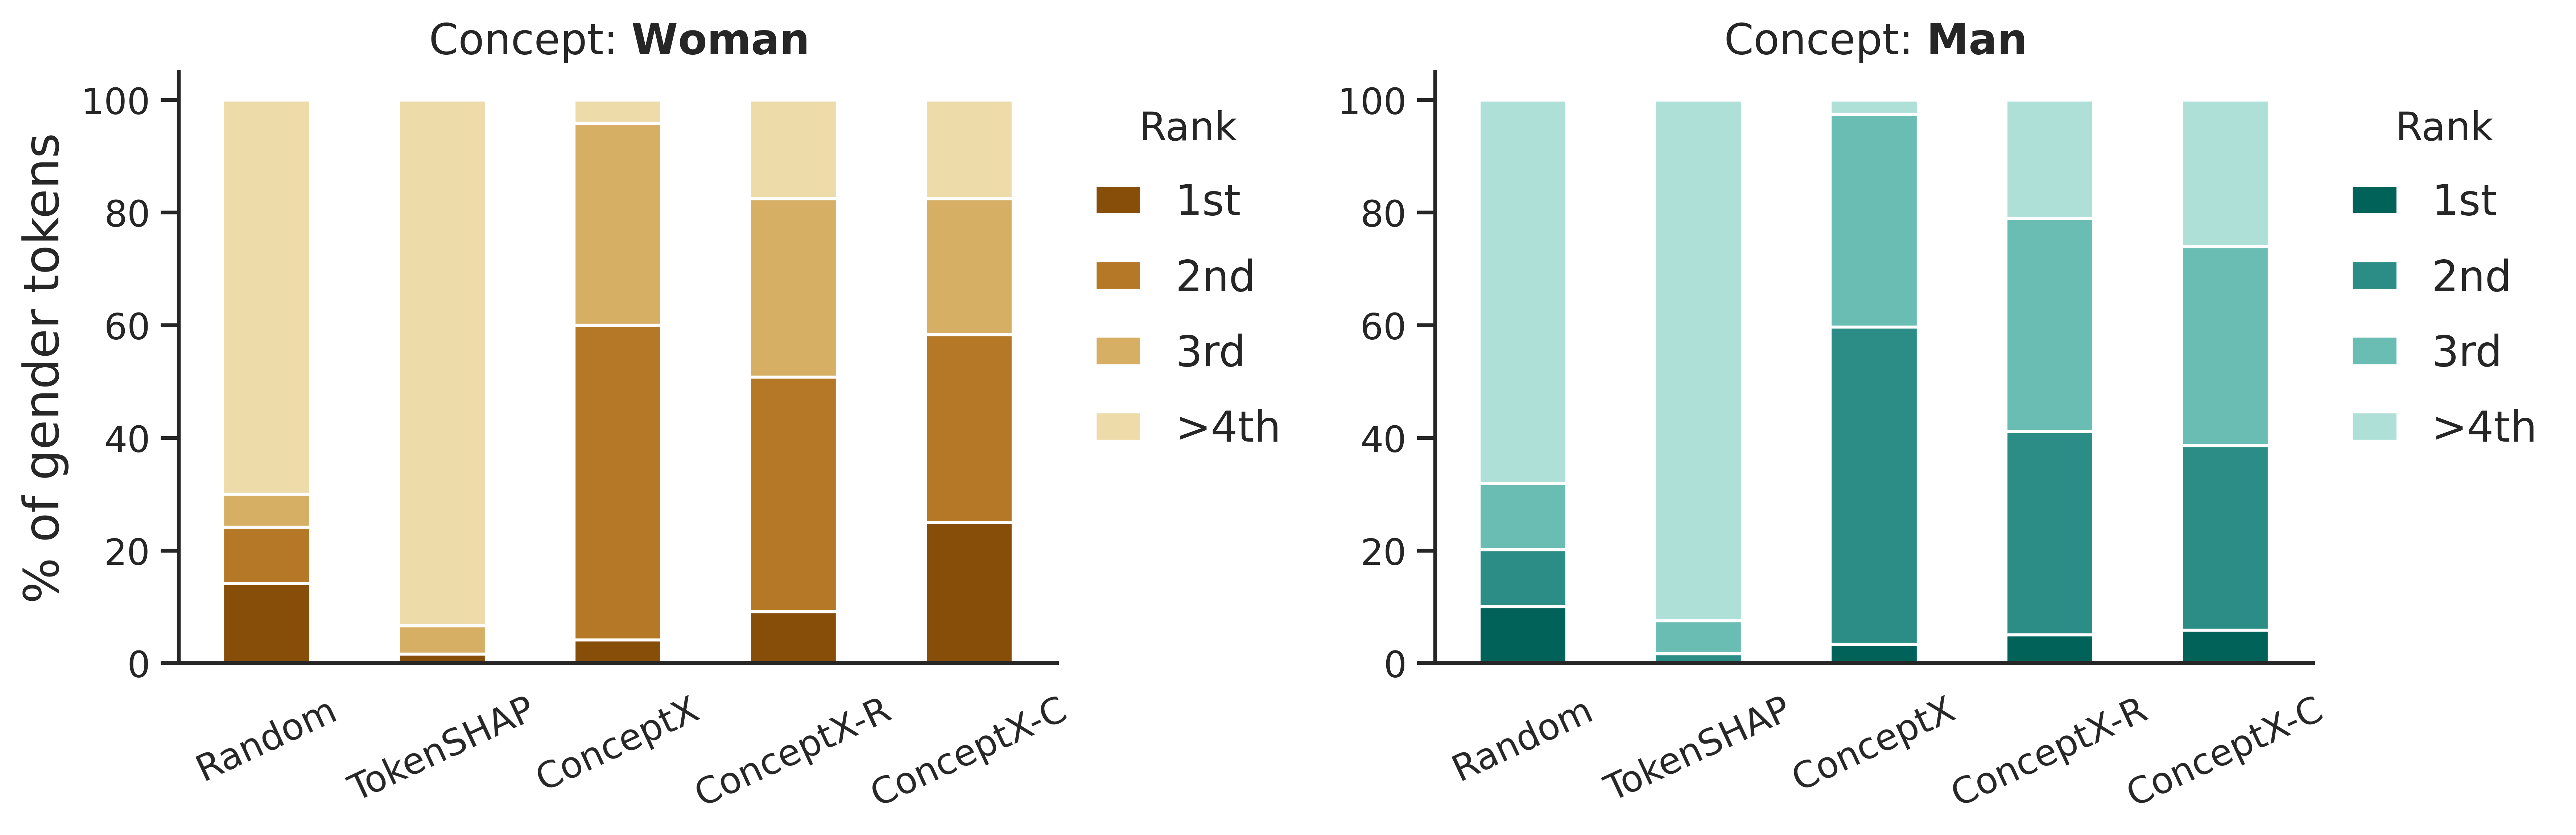

In [31]:
# Set up the plot style and context
sns.set_style("ticks")
sns.set_context("notebook", rc={"xtick.labelsize": 12, "ytick.labelsize": 12})

# Create a figure with two subplots (man on the left and woman on the right)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Define the BrBG colormap
brbg_palette = sns.color_palette("BrBG", n_colors=10)  # Adjust the number of colors as needed

# Split the colormap: lighter (yellowish) for women, darker (bluish) for men
colors_woman = brbg_palette[:len(df_woman.columns)]  # First half
colors_man = brbg_palette[-len(df_man.columns):][::-1]  # Second half

# Plot for woman
df_woman.plot(kind='bar', stacked=True, 
              color=colors_woman, 
              width=0.5, edgecolor='white', ax=axes[0])

axes[0].set_title(r"Concept: $\mathbf{Woman}$", fontsize=14)
axes[0].set_xlabel('')
axes[0].set_ylabel('% of gender tokens', fontsize=16)
axes[0].tick_params(axis='x', which='both', bottom=False)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_xticklabels(df_woman.index, rotation=25)

# Plot for man
df_man.plot(kind='bar', stacked=True, 
            color=colors_man, 
            width=0.5, edgecolor='white', ax=axes[1])

axes[1].set_title("Concept: $\mathbf{Man}$", fontsize=14)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].tick_params(axis='x', which='both', bottom=False)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].set_xticklabels(df_man.index, rotation=25)

# Add legends for both plots
leg = axes[0].legend(labels=['1st', '2nd', '3rd', '>4th'], title='Rank', bbox_to_anchor=(1, 1), fontsize=14, loc='upper left', frameon=False, handlelength=1.1, labelspacing=0.8)
leg.get_title().set_fontsize('13')
for line in leg.get_lines():
    line.set_linewidth(3)
    
# Add legends for both plots
leg = axes[1].legend(labels=['1st', '2nd', '3rd', '>4th'], title='Rank', bbox_to_anchor=(1, 1), fontsize=14, loc='upper left', frameon=False, handlelength=1.1, labelspacing=0.8)
leg.get_title().set_fontsize('13')
for line in leg.get_lines():
    line.set_linewidth(3)

# Remove spines and adjust spacing
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(save_dir, f"figures/accuracy/manwoman_rank_{model_name}_{dataset}.pdf"), bbox_inches='tight', dpi=600)

# Show the plot
plt.show()


In [37]:
model_map = MODEL_NAMES
model_order = ["GPT-2", "GPT-4o-mini", "Llama-3.2-3B"]

/tmp/ipykernel_2460254/2158044646.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["explainer"] = df["explainer"].replace(explainer_map)
/tmp/ipykernel_2460254/2158044646.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["explainer"] = pd.Categorical(df["explainer"], categories=explainer_order, ordered=True)
/tmp/ipykernel_2460254/2158044646.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

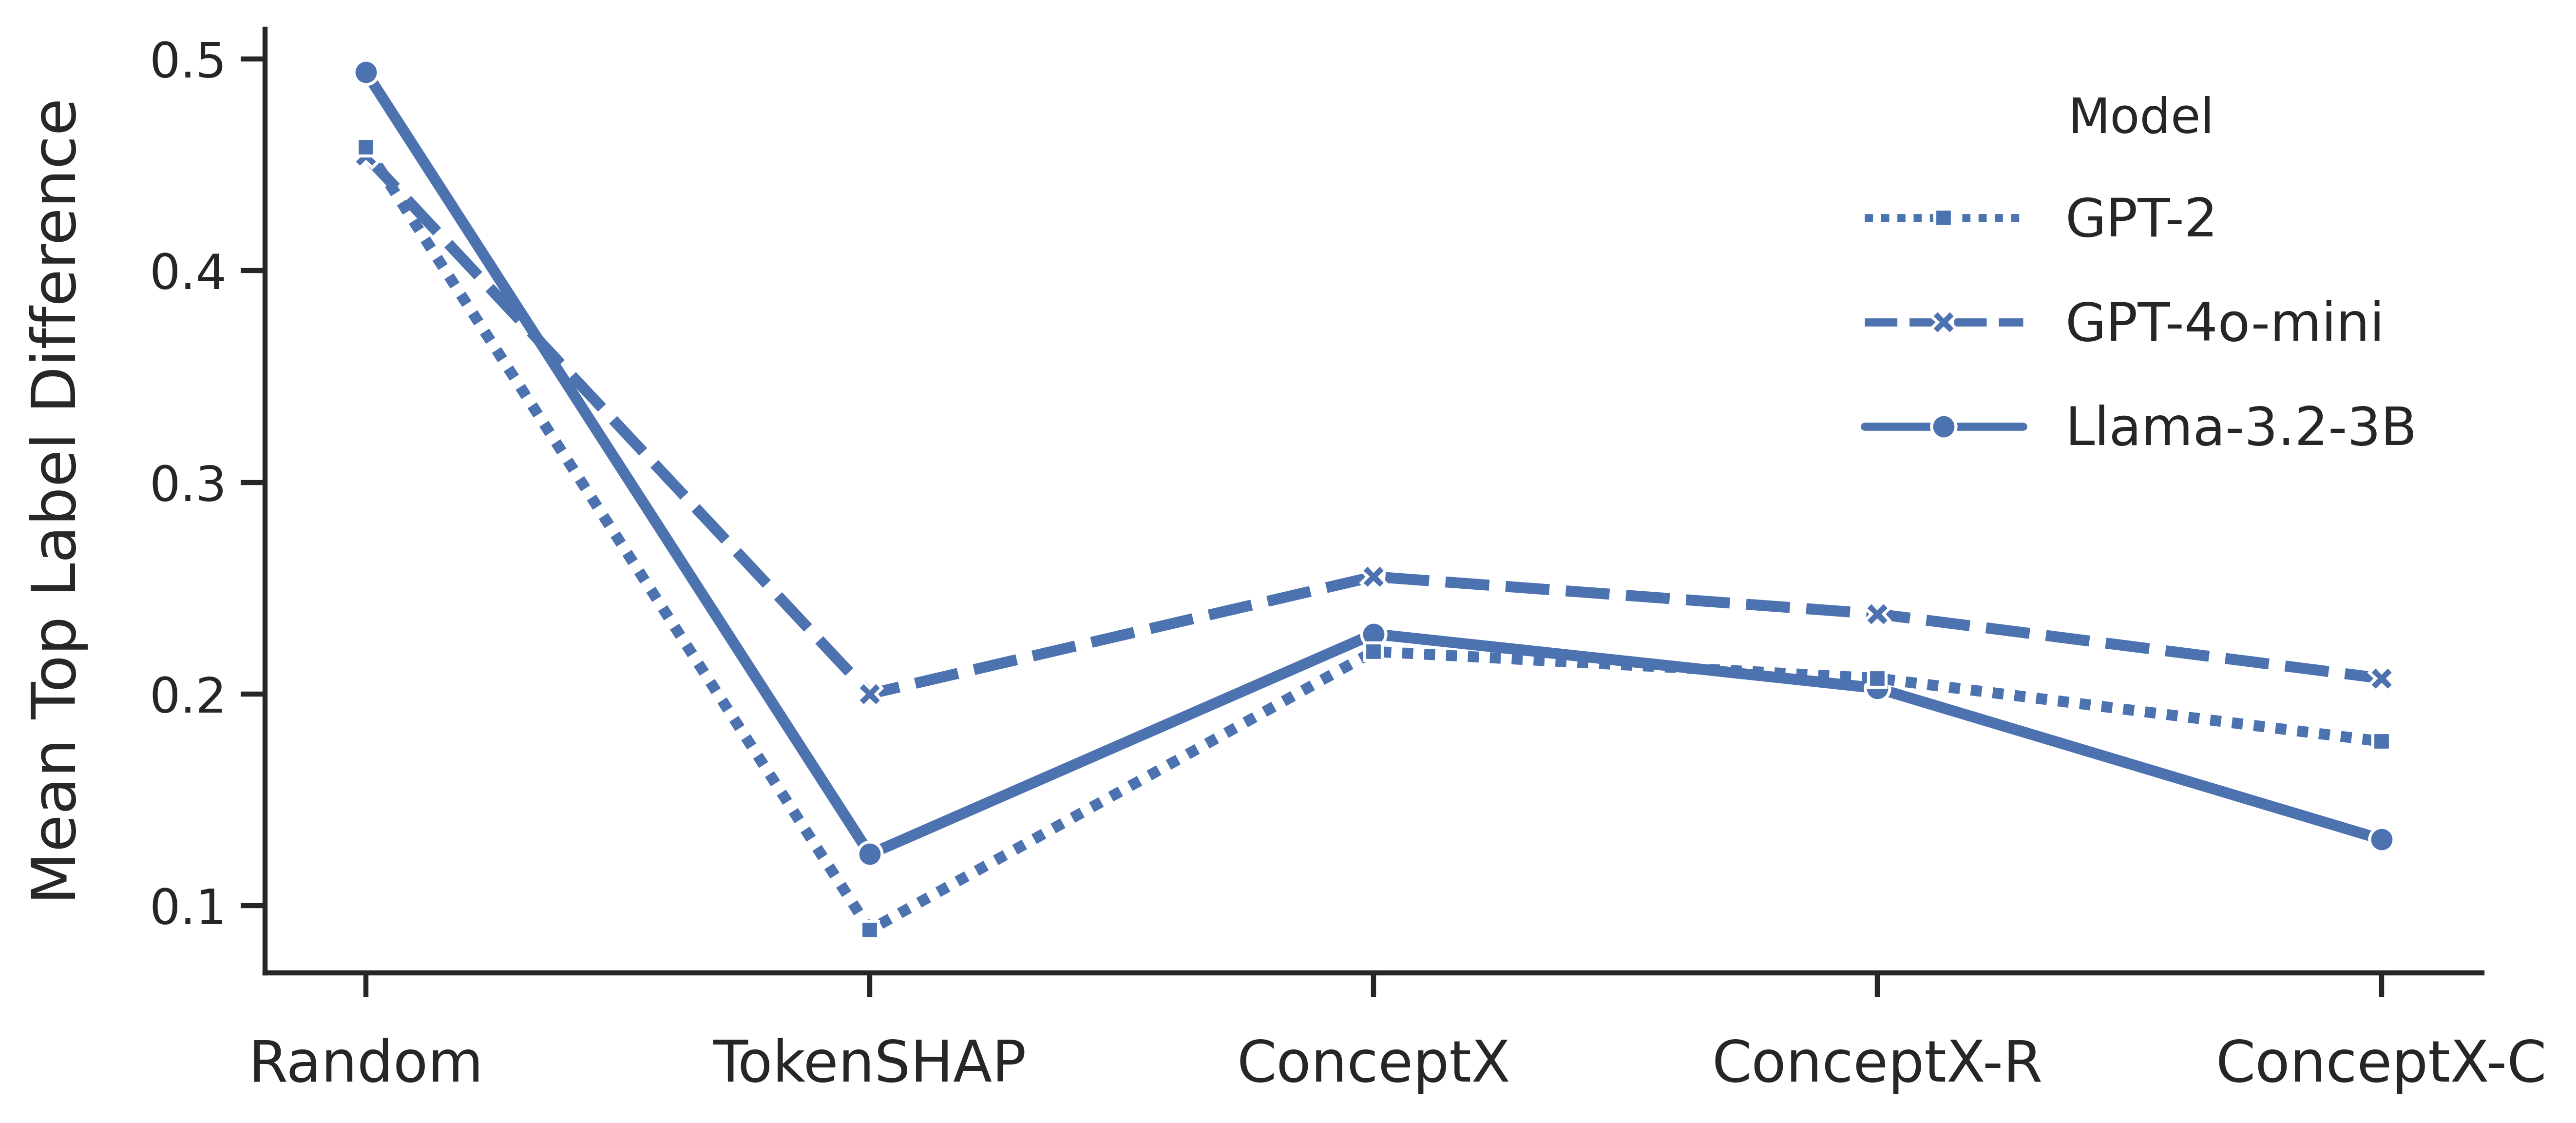

In [48]:
df = df_all[(df_all["dataset"]==dataset)&(df_all["model"]!="gpt4")]
df["explainer"] = df["explainer"].replace(explainer_map)
df["explainer"] = pd.Categorical(df["explainer"], categories=explainer_order, ordered=True)
df["model"] = df["model"].replace(model_map)
#df["model"] = pd.Categorical(df["model"], categories=model_order, ordered=True)

# Set plot aesthetics
sns.set_style("ticks")
sns.set_context("notebook", rc={"xtick.labelsize": 15, "ytick.labelsize": 15})

# Create a single plot
plt.figure(figsize=(9, 4))

sns.lineplot(
    data=df, 
    x="explainer", 
    y="top_label_difference", 
    style="model",  # Different models get different line styles (dashes)
    markers=True,  # Add markers for visibility
    errorbar=None,
    linewidth=2.7
)

# Formatting
plt.xlabel('')
plt.ylabel("Mean Top Label Difference", fontsize=15, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.tick_params(axis='x', which='major', pad=10)
# Create a single legend at the top, vertically
handles, labels = plt.gca().get_legend_handles_labels()
ordered_handles = [handles[labels.index(label)] for label in model_order]
ordered_labels = [label for label in model_order]

legend = plt.legend(
    ordered_handles, ordered_labels, loc='upper left', title="Model",
    bbox_to_anchor=(0.7, 0.98), ncol=1, fontsize=13, frameon=False,
    handlelength=3, labelspacing=1  # Adjust thickness of legend handle, decrease length of line
)

for line in legend.get_lines():
    line.set_linewidth(2)  # Increase line width in legend
    
sns.despine()
plt.tight_layout()

plt.savefig(os.path.join(save_dir, f"figures/accuracy/toplabeldiff_{dataset}.pdf"), bbox_inches='tight', dpi=600)

plt.show()

/tmp/ipykernel_2460254/1666628042.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["explainer"] = df["explainer"].replace(explainer_map)
/tmp/ipykernel_2460254/1666628042.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["explainer"] = pd.Categorical(df["explainer"], categories=explainer_order, ordered=True)
/tmp/ipykernel_2460254/1666628042.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

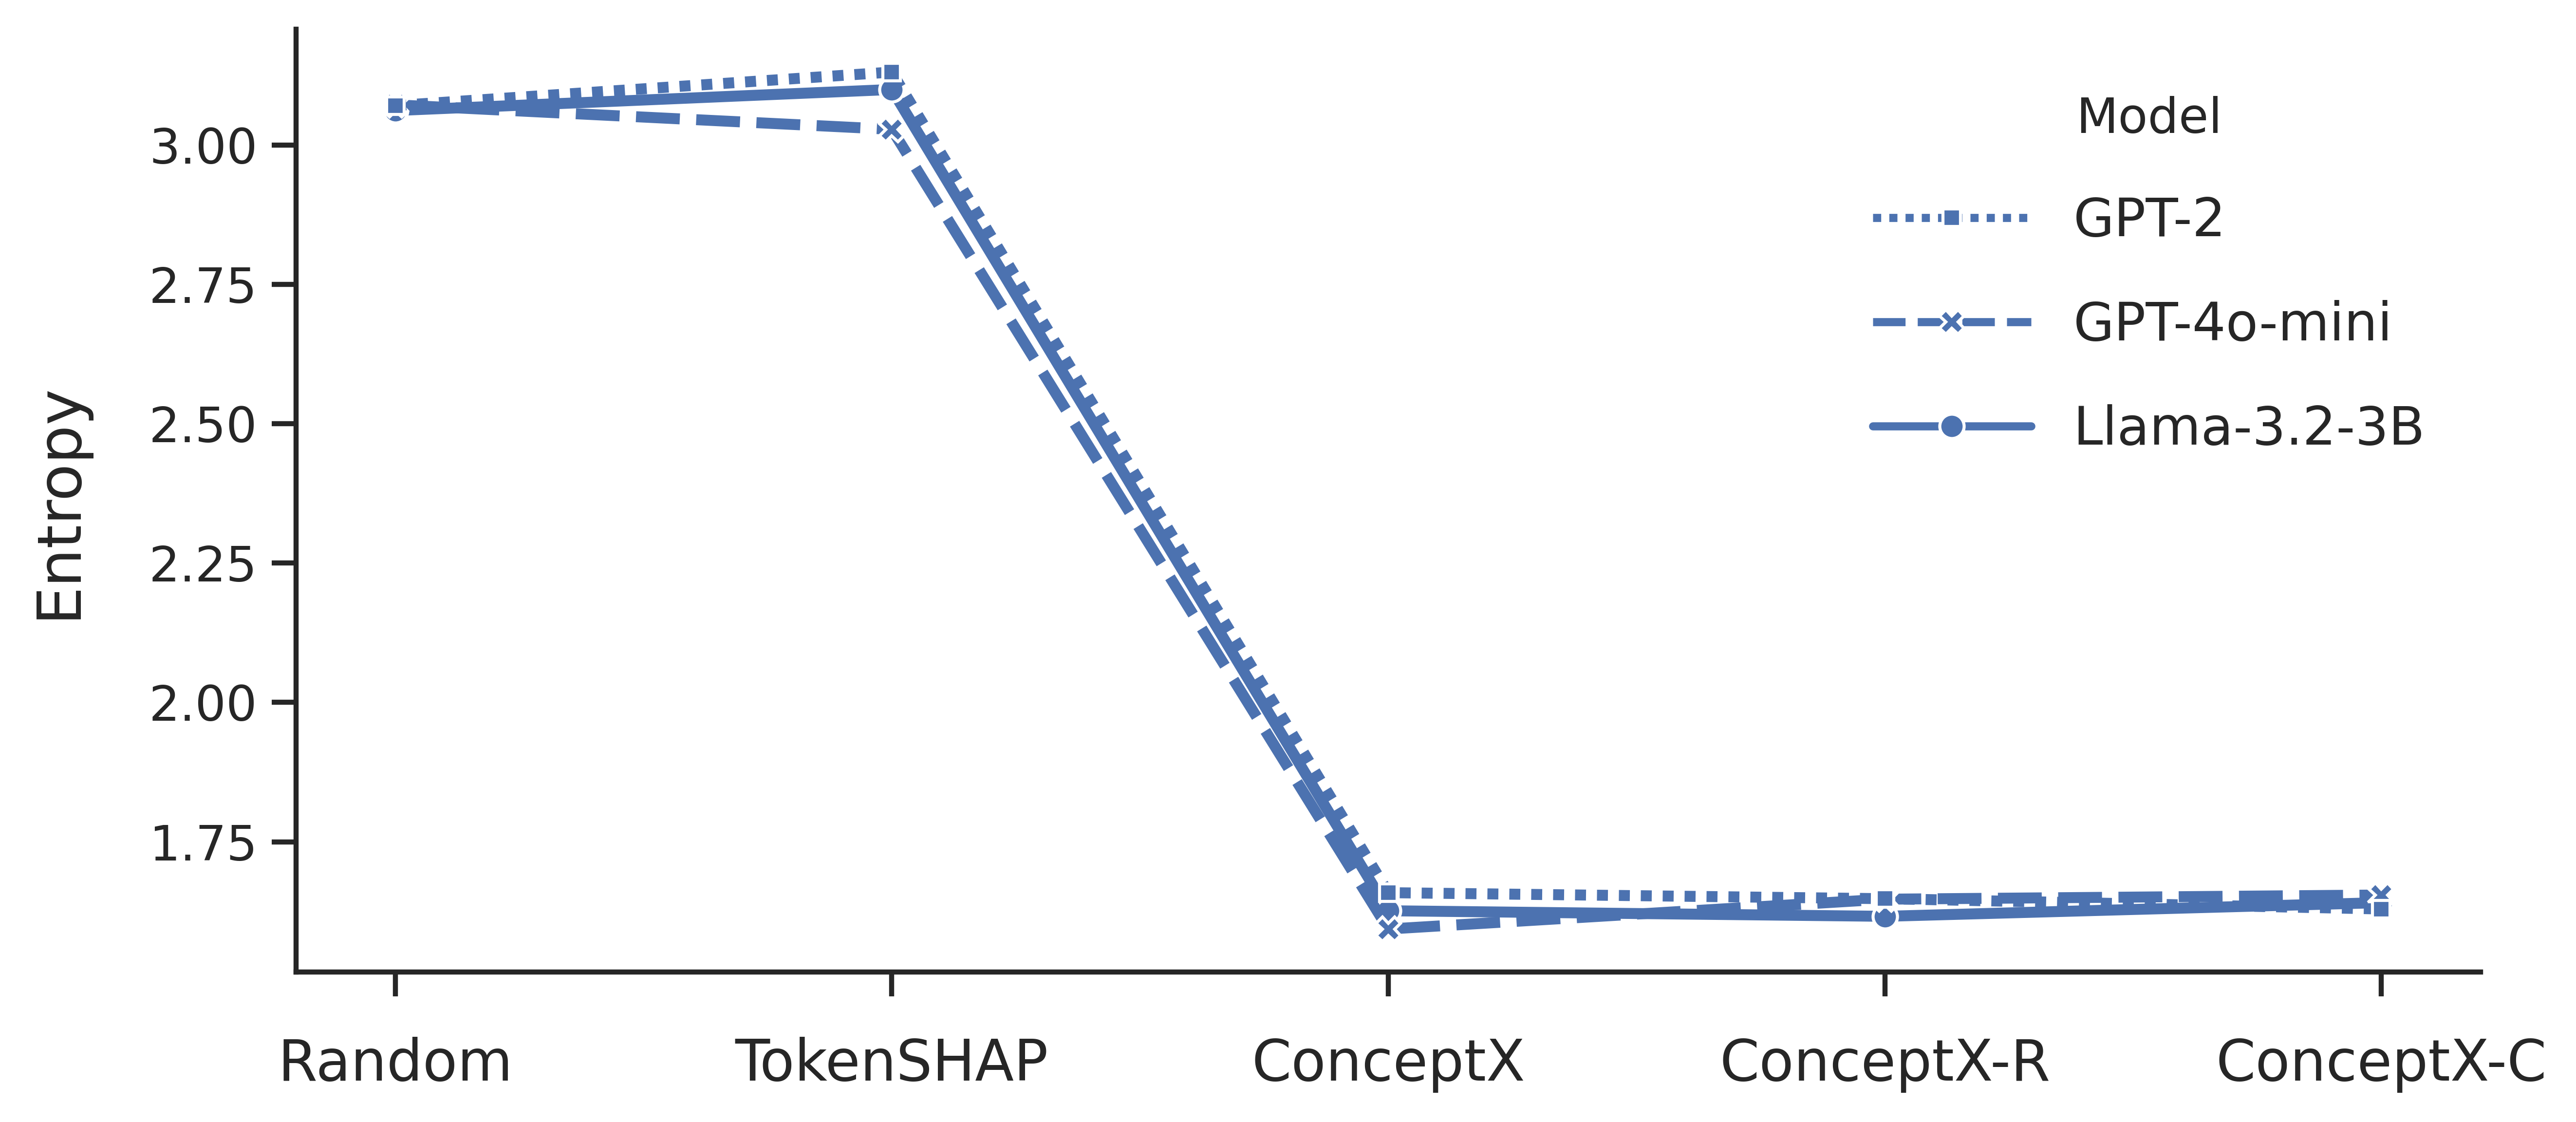

In [50]:
df = df_all[(df_all["dataset"]==dataset)&(df_all["model"]!="gpt4")]
df["explainer"] = df["explainer"].replace(explainer_map)
df["explainer"] = pd.Categorical(df["explainer"], categories=explainer_order, ordered=True)
df["model"] = df["model"].replace(model_map)

# Set plot aesthetics
sns.set_style("ticks")
sns.set_context("notebook", rc={"xtick.labelsize": 15, "ytick.labelsize": 15})

# Create a single plot
plt.figure(figsize=(9, 4))

sns.lineplot(
    data=df, 
    x="explainer", 
    y="entropy", 
    style="model",  # Different models get different line styles (dashes)
    markers=True,  # Add markers for visibility
    errorbar=None,
    linewidth=2.7
)

# Formatting
plt.xlabel('')
plt.ylabel("Entropy", fontsize=15, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.tick_params(axis='x', which='major', pad=10)
# Create a single legend at the top, vertically
handles, labels = plt.gca().get_legend_handles_labels()
ordered_handles = [handles[labels.index(label)] for label in model_order]
ordered_labels = [label for label in model_order]

legend = plt.legend(
    ordered_handles, ordered_labels, loc='upper left', title="Model",
    bbox_to_anchor=(0.7, 0.98), ncol=1, fontsize=13, frameon=False,
    handlelength=3, labelspacing=1  # Adjust thickness of legend handle, decrease length of line
)

for line in legend.get_lines():
    line.set_linewidth(2)  # Increase line width in legend
    
sns.despine()
plt.tight_layout()
fig.savefig(os.path.join(save_dir, f"figures/accuracy/entropy_{dataset}.pdf"), bbox_inches='tight', dpi=600)

# Show plot
plt.show()

In [54]:
# Group by 'model' and calculate the mean and variance of 'entropy'
df = summary_df[summary_df["model"]!="gpt4"]
df["explainer"] = df["explainer"].replace(explainer_map)
df["explainer"] = pd.Categorical(df["explainer"], categories=explainer_order, ordered=True)
entropy_stats = df.groupby('explainer')['entropy'].agg(['mean', 'var']).reset_index()
entropy_stats

/tmp/ipykernel_2460254/2032302958.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["explainer"] = df["explainer"].replace(explainer_map)
/tmp/ipykernel_2460254/2032302958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["explainer"] = pd.Categorical(df["explainer"], categories=explainer_order, ordered=True)
/tmp/ipykernel_2460254/2032302958.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cur

,explainer,mean,var
0,Random,3.068089,0.000031
1,TokenSHAP,3.086060,0.002773
2,ConceptX,1.626259,0.001062
3,ConceptX-R,1.637151,0.000324
4,ConceptX-C,1.641683,0.000157
